## 1. Import Data


In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.device('/GPU:0')

Defining vector space dimension and fixed input size

In [4]:
# Number of labels
num_classes = 6

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['happiness', 'sadness', 'anger', 'fear', 'surprise', 'disgust']

Importing the dataset to split into training and testing set

In [ ]:
data = pd.read_csv('raw_data/emotion_data_merged_4.csv')
data

,sentence,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,happiness
4,i was feeling a little vain when i did this one,sadness
...,...,...
662394,Witnessing the destruction of a natural habita...,disgust
662395,The vulgar display of wealth amidst poverty wa...,disgust
662396,The disregard for personal space and boundarie...,disgust
662397,Their manipulation of others' emotions for per...,disgust


In [24]:
# Assuming 'df' is your DataFrame
# This line drops rows where the 'sentence' column has NaN values
data = data.dropna(subset=['sentence'])

# Now, 'df' will only contain rows where the 'sentence' column is not NaN
data

,sentence,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,happiness
4,i was feeling a little vain when i did this one,sadness
...,...,...
662394,Witnessing the destruction of a natural habita...,disgust
662395,The vulgar display of wealth amidst poverty wa...,disgust
662396,The disregard for personal space and boundarie...,disgust
662397,Their manipulation of others' emotions for per...,disgust


In [25]:
data.value_counts('emotion')

emotion
happiness    190250
neutral      182373
sadness      122251
anger         59703
surprise      55308
fear          44267
disgust        7361
Name: count, dtype: int64

In [26]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [27]:
df_train_cleaned = data_train.dropna(subset=['emotion'])

In [28]:
df_test_cleaned = data_test.dropna(subset=['emotion'])

In [29]:
X_train = df_train_cleaned['sentence']
X_test = df_test_cleaned['sentence']
y_train = df_train_cleaned['emotion']
y_test = df_test_cleaned['emotion']

In [30]:

print("\n\nTraining set:", len(X_train))
print("\nTesting set:", len(X_test))



Training set: 529192

Testing set: 132321


<Axes: xlabel='emotion'>

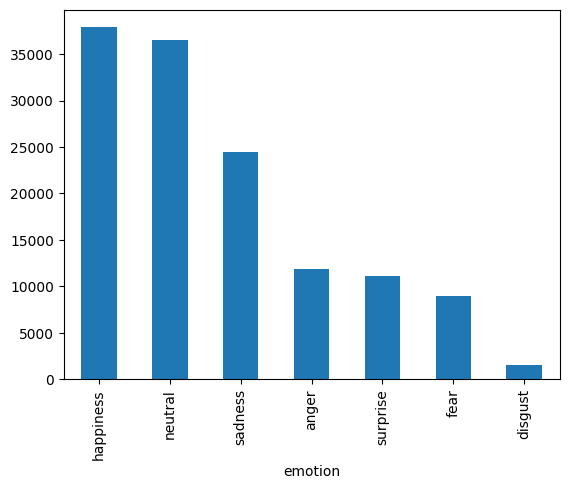

In [31]:
y_test.value_counts().plot(kind='bar')

<Axes: xlabel='emotion'>

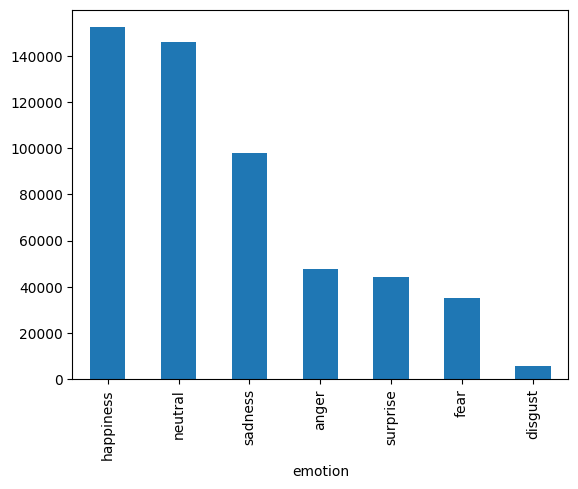

In [32]:
y_train.value_counts().plot(kind='bar')

## 2. Prepare input data

In [33]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [34]:
texts = [' '.join(clean_text(text)) for text in data.sentence]

In [35]:
texts_train = [' '.join(clean_text(text)) for text in X_train]

In [36]:
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [37]:
print(texts_test[74])

i feel like i have to always smile and always talk to someone i just want to not look ecstatic for one second without someone worrying about me


**Tokenization + fitting using keras**

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 90034


In [39]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,  2428,     5, 40773],
       [    0,     0,     0, ...,     2,   266,   567],
       [    0,     0,     0, ...,    31,    24,   524],
       ...,
       [    0,     0,     0, ...,     4,     2,   451],
       [    0,     0,     0, ...,   248,    28,   738],
       [    0,     0,     0, ...,   102,    51,  3632]])

**Categorize** labels: 

In [40]:
encoding = {
    'happiness': 0,
    'sadness': 1,
    'neutral': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5,
    'disgust': 6
}

In [41]:
# Use the map function to transform each emotion to its corresponding integer encoding
y_train_encoded = y_train.map(encoding)

# Or
y_train_array = y_train_encoded.to_numpy()

# y_train_array is now an array of integers representing the emotions according to your encoding
y_train_array

array([3, 5, 0, ..., 0, 0, 1], dtype=int64)

In [42]:
# Use the map function to transform each emotion to its corresponding integer encoding
y_test_encoded = y_test.map(encoding)

# Or
y_test_array = y_test_encoded.to_numpy()

# y_train_array is now an array of integers representing the emotions according to your encoding
y_test_array


array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [43]:
# Integer labels
y_train = [encoding[x] for x in df_train_cleaned.emotion]
y_test = [encoding[x] for x in df_test_cleaned.emotion]

In [44]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## Import pretrained word vectors

In [45]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [47]:
import urllib.request
import zipfile
import os

fname = 'embeddings/crawl-300d-2M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip',
                              'crawl-300d-2M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('crawl-300d-2M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('crawl-300d-2M.vec.zip')

In [48]:
fname = 'embeddings/crawl-300d-2M.vec'

In [49]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(90035, 300)

In [50]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in crawl vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in crawl vocab: 70893
New words found: 19141


## Create CNN Pipeline

In [51]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [52]:
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [53]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          27010500  
                                                                 
 conv1d (Conv1D)             (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 27,308,747
Trainable params: 298,247
Non-trainable params: 27,010,500
______________________________________

## Train the Model

In [54]:
X_train_pad.shape, y_train.shape

((529192, 500), (529192, 7))

In [55]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)  # Stop training if validation loss doesn't improve for 3 epochs

In [56]:
batch_size = 512
epochs = 55

# Train the model with early stopping
hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad, y_test),
                 callbacks=[early_stopping])


Epoch 1/55


1034/1034 [==============================] - 92s 78ms/step - loss: 0.2938 - accuracy: 0.9057 - val_loss: 0.2119 - val_accuracy: 0.9312
Epoch 2/55
1034/1034 [==============================] - 80s 77ms/step - loss: 0.1880 - accuracy: 0.9376 - val_loss: 0.2011 - val_accuracy: 0.9339
Epoch 3/55
1034/1034 [==============================] - 80s 77ms/step - loss: 0.1608 - accuracy: 0.9458 - val_loss: 0.2032 - val_accuracy: 0.9346
Epoch 4/55
1034/1034 [==============================] - 80s 77ms/step - loss: 0.1401 - accuracy: 0.9523 - val_loss: 0.2051 - val_accuracy: 0.9345
Epoch 5/55
1034/1034 [==============================] - 80s 78ms/step - loss: 0.1222 - accuracy: 0.9579 - val_loss: 0.2231 - val_accuracy: 0.9337
Epoch 6/55
1034/1034 [==============================] - 81s 78ms/step - loss: 0.1078 - accuracy: 0.9623 - val_loss: 0.2382 - val_accuracy: 0.9288
Epoch 7/55
1034/1034 [==============================] - 85s 82ms/step - loss: 0.0944 - accuracy: 0.9666 - val_loss: 0.2523 - val_accura

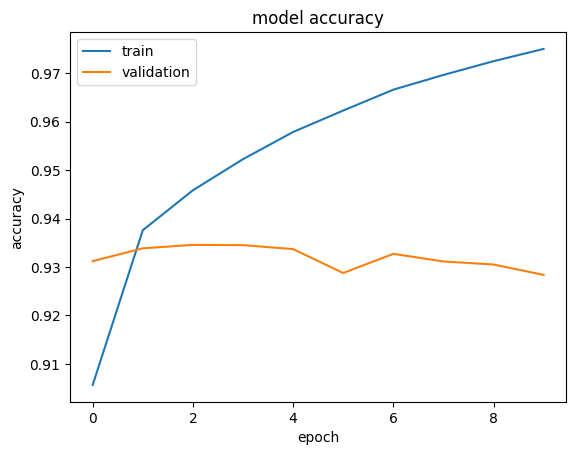

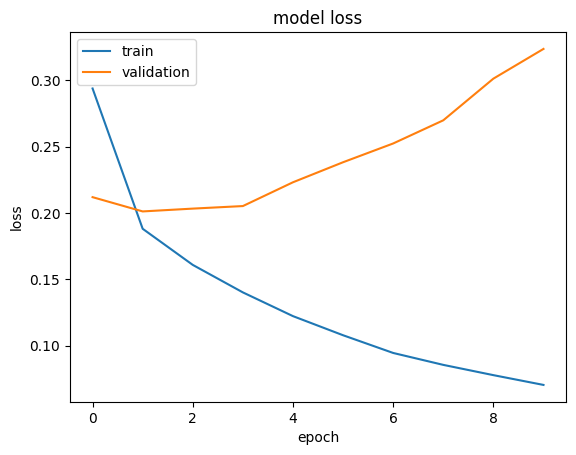

In [57]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

In [58]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

4136/4136 [==============================] - 17s 4ms/step


In [59]:
print("Accuracy: {:.2f}%".format(accuracy_score(df_test_cleaned.emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df_test_cleaned.emotion, predictions, average='micro') * 100))

Accuracy: 93.39%

F1 Score: 93.39


#### Plotting confusion Matrix:

In [60]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 93.39


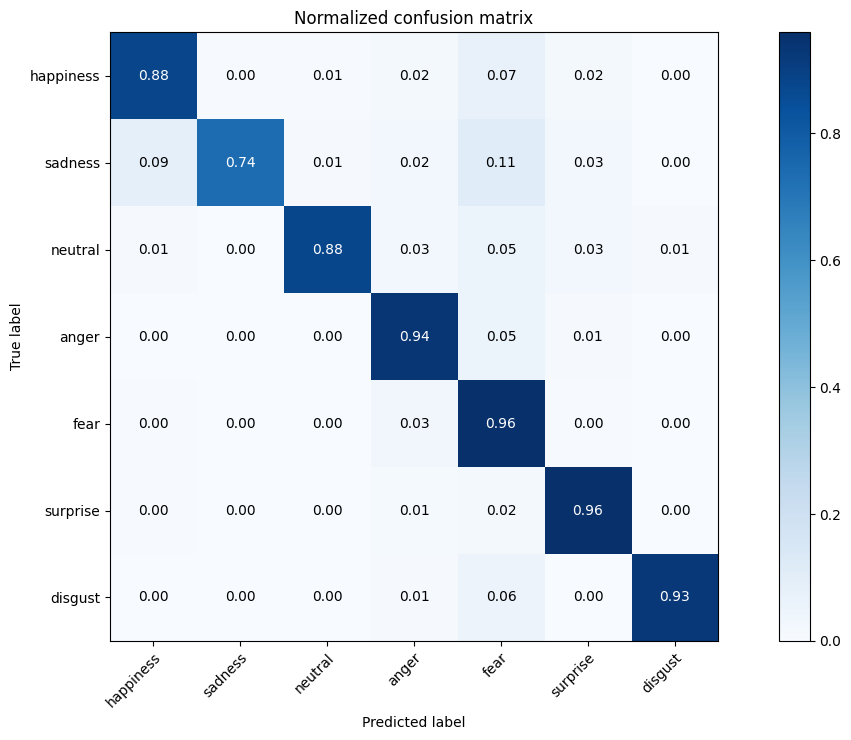

In [61]:
print("\nF1 Score: {:.2f}".format(f1_score(df_test_cleaned.emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(df_test_cleaned.emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [62]:
import time

message = ['I am so sad at you!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 35ms/step
Message: ['I am so sad at you!']
predicted: sadness (0.10 seconds)


In [63]:
kaggle_data = pd.read_csv('raw_data/kaggle_data.csv', sep='\t')
kaggle_data

,id,sentence
0,0,Girls are happy when they get flowers
1,1,His jaw dropped in disbelief when he saw the p...
2,2,Sometimes the ugly stench makes me wanna throw...
3,3,The foul odor from the garbage bin was disgust...
4,4,"I can’t believe it, they lost the game in the ..."
...,...,...
1431,1431,I feel guilty about the ice cream I stole as a...
1432,1432,Her ability to recall obscure facts never ceas...
1433,1433,"Your cat is so cute, I love him."
1434,1434,She remained skeptical about the new product.


In [64]:
# Function to predict emotion for a given sentence
def predict_emotion(sentence):
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=max_seq_len)
    pred = model.predict(padded, verbose = 0)
    return class_names[np.argmax(pred)]

In [65]:
# Apply predict_emotion function to each sentence in the DataFrame
kaggle_data['emotion'] = kaggle_data['sentence'].apply(predict_emotion)

In [66]:
kaggle_data.value_counts('emotion')

emotion
neutral      374
happiness    250
anger        218
sadness      205
fear         171
disgust      109
surprise     109
Name: count, dtype: int64

In [67]:
kaggle_data

,id,sentence,emotion
0,0,Girls are happy when they get flowers,neutral
1,1,His jaw dropped in disbelief when he saw the p...,surprise
2,2,Sometimes the ugly stench makes me wanna throw...,disgust
3,3,The foul odor from the garbage bin was disgust...,disgust
4,4,"I can’t believe it, they lost the game in the ...",neutral
...,...,...,...
1431,1431,I feel guilty about the ice cream I stole as a...,sadness
1432,1432,Her ability to recall obscure facts never ceas...,surprise
1433,1433,"Your cat is so cute, I love him.",happiness
1434,1434,She remained skeptical about the new product.,neutral


In [68]:
# Creating new dataframe without the sentence column:
kaggle_submission = kaggle_data.drop('sentence', axis=1)

In [69]:
kaggle_submission.to_csv('submission_6_CNN.csv', index=False)

In [70]:
# creates a HDF5 file 'my_model.h5'
model.save('models/cnn_w2v_6.h5')